In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# import timeit
from scipy.integrate import odeint
from scipy import stats
from sklearn.manifold import MDS
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org

In [2]:
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# c = lambda t: 2+2*t/256+np.sin(t)
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)

In [3]:
nyears = 1

settlingTime = 2 ** 10
tlen = 2 ** 9
end = 2**11 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1

# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [4]:
def driverVdelta(resolution):
    # Final data will be
    # Nonstat Rate(0,1)|thetaNS|deltaNS|errNS(l1o)|errNS(seq)|lagNS|dofNS|thetaS|errS(l1o)|errS(seq)|lagS|dofS
    
    table = np.zeros((resolution, 12))
    
    x0 = np.array([0.1,0.4,9])
    for r in range(resolution):
        rate = float(r)/resolution
        b1 = lambda t: 2.5 + rate * 4 * t / end
        
        Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]

        predictionHorizon = 1
        lagStep = 1
        maxLags = 6
        
        plotTS(Xr)
        
        thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep)
        
        Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)
        dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

        Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagsS, lagStep, t=t)
        dofS = dofestimation(Xs, Ys, txs, thetaNS, 0)
        
        MSENS, sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS, returnSeries=True)
        MSES, sequentialS = sequential(Xs, Ys, txs, thetaS, 0, returnSeries=True)
        
        stinky = np.array([rate,thetaNS,deltaNS,errNS,MSENS,lagsNS,dofNS,thetaS,errS,MSES,lagsS,dofS])
        for pp in range(12):
            table[r,pp] = stinky[pp]
            
        AkaikeTest(errNS, errS, dofNS, dofS, Xr.shape[0])
        
    return table

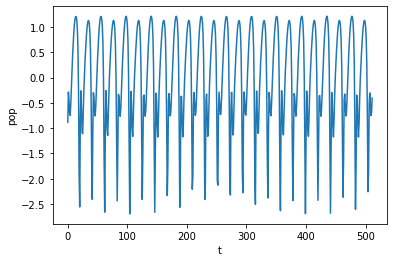

NSMap: 
 Min error 0.00029622536857724176 
 Optimal Lags: 6 
 Theta: 17.53116706110001 
 Delta: 0.0
SMap: 
 Min error 0.00029622536857724176 
 Optimal Lags: 6 
 Theta: 17.53116706110001
Probability NSMap beats SMap:  1.0


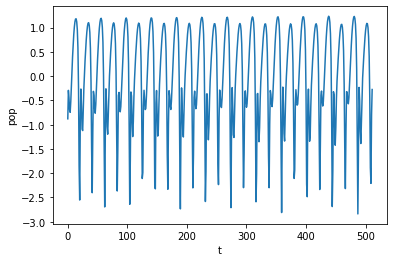

NSMap: 
 Min error 0.002295485509704574 
 Optimal Lags: 5 
 Theta: 26.97498335832412 
 Delta: 0.40314085006250033
SMap: 
 Min error 0.0028454454978205706 
 Optimal Lags: 6 
 Theta: 23.522712143931017
Probability SMap beats NSMap:  4.1068379211999216e-21


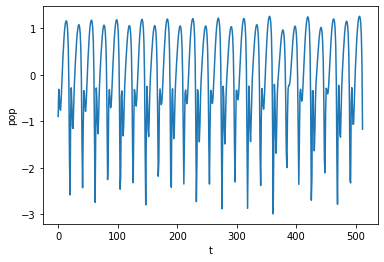

NSMap: 
 Min error 0.0110462244718356 
 Optimal Lags: 6 
 Theta: 30.772481694156536 
 Delta: 0.13160383121875002
SMap: 
 Min error 0.02403524537676341 
 Optimal Lags: 6 
 Theta: 21.953497955570516
Probability SMap beats NSMap:  1.0067674007724526e-83


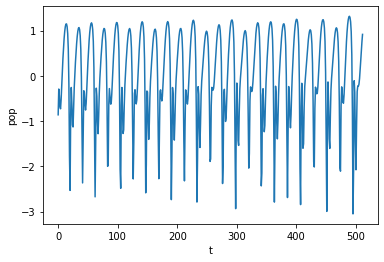

NSMap: 
 Min error 0.018114890864670156 
 Optimal Lags: 6 
 Theta: 20.227362348373962 
 Delta: 0.0
SMap: 
 Min error 0.041046052251513254 
 Optimal Lags: 6 
 Theta: 21.09043015197224
Probability SMap beats NSMap:  1.1472763293517974e-91


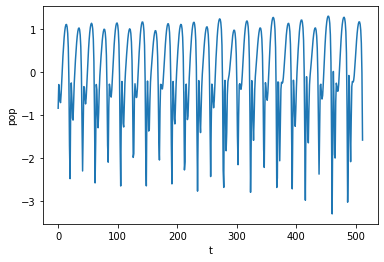

NSMap: 
 Min error 0.06567959555923847 
 Optimal Lags: 6 
 Theta: 21.953497955570516 
 Delta: 0.0
SMap: 
 Min error 0.1278884375864706 
 Optimal Lags: 6 
 Theta: 13.758450755500007
Probability SMap beats NSMap:  8.19204219882979e-75


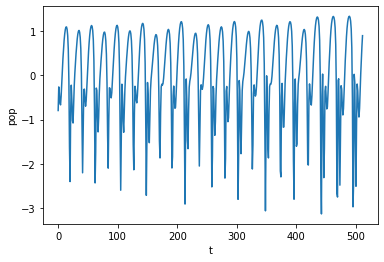

NSMap: 
 Min error 0.10446209371414161 
 Optimal Lags: 4 
 Theta: 19.671004590682514 
 Delta: 0.49166765656250033
SMap: 
 Min error 0.14414826032398192 
 Optimal Lags: 6 
 Theta: 13.110015140475006
Probability SMap beats NSMap:  2.4422925659727732e-42


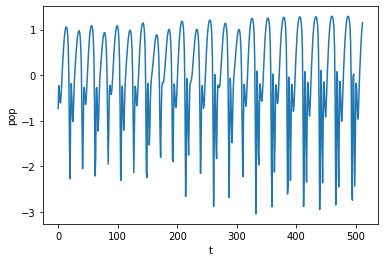

NSMap: 
 Min error 0.09362425323545503 
 Optimal Lags: 4 
 Theta: 18.957725414155014 
 Delta: 0.0
SMap: 
 Min error 0.13312065344835078 
 Optimal Lags: 6 
 Theta: 14.347937678250007
Probability SMap beats NSMap:  1.023703766441808e-59


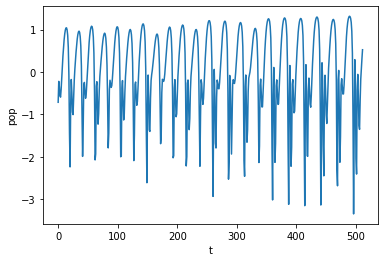

NSMap: 
 Min error 0.10124818954041825 
 Optimal Lags: 4 
 Theta: 17.9769665464297 
 Delta: 0.0
SMap: 
 Min error 0.13502835038569366 
 Optimal Lags: 4 
 Theta: 19.671004590682514
Probability SMap beats NSMap:  9.780247944554287e-33


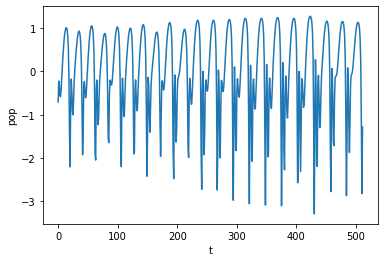

NSMap: 
 Min error 0.20430858987528477 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.0
SMap: 
 Min error 0.3141703468582844 
 Optimal Lags: 4 
 Theta: 19.671004590682514
Probability SMap beats NSMap:  1.834337286788937e-67


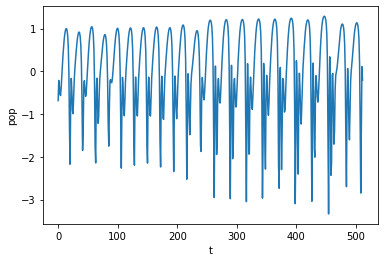

NSMap: 
 Min error 0.13428723085257782 
 Optimal Lags: 4 
 Theta: 16.55851363856251 
 Delta: 0.0
SMap: 
 Min error 0.2327360395145758 
 Optimal Lags: 4 
 Theta: 15.164377066258757
Probability SMap beats NSMap:  7.240959858358037e-62


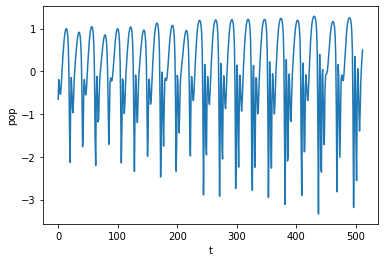

NSMap: 
 Min error 0.141808355457876 
 Optimal Lags: 4 
 Theta: 18.367308575784378 
 Delta: 0.0
SMap: 
 Min error 0.28798176970708733 
 Optimal Lags: 4 
 Theta: 18.604652221773904
Probability SMap beats NSMap:  1.7307208892908395e-79


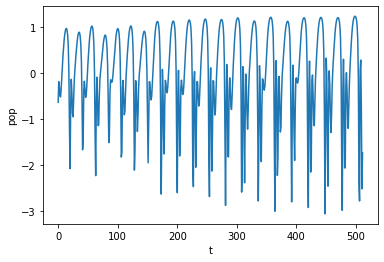

NSMap: 
 Min error 0.12265600883423235 
 Optimal Lags: 4 
 Theta: 14.672155485762508 
 Delta: 0.5056389765625
SMap: 
 Min error 0.21698878533404037 
 Optimal Lags: 5 
 Theta: 18.173118319974765
Probability SMap beats NSMap:  1.9442355925234242e-58


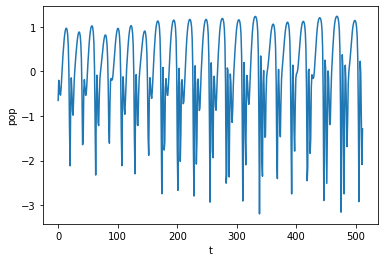

NSMap: 
 Min error 0.18849627575121727 
 Optimal Lags: 3 
 Theta: 18.604652221773904 
 Delta: 0.6046102248046875
SMap: 
 Min error 0.2715236234216778 
 Optimal Lags: 5 
 Theta: 18.173118319974765
Probability SMap beats NSMap:  7.517677271591082e-47


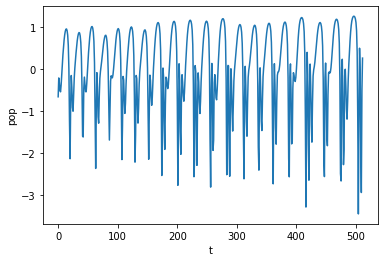

NSMap: 
 Min error 0.17200841341875564 
 Optimal Lags: 3 
 Theta: 15.913320201612631 
 Delta: 0.0
SMap: 
 Min error 0.25305933426136784 
 Optimal Lags: 5 
 Theta: 15.521016654522507
Probability SMap beats NSMap:  1.0235994860855994e-72


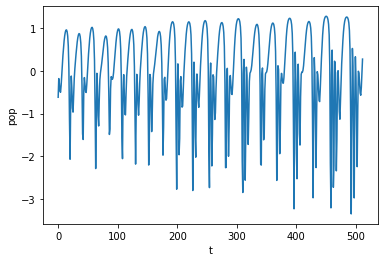

NSMap: 
 Min error 0.27136647915952006 
 Optimal Lags: 4 
 Theta: 15.913320201612631 
 Delta: 0.2808881341406251
SMap: 
 Min error 0.570315237161819 
 Optimal Lags: 5 
 Theta: 15.342696860390632
Probability SMap beats NSMap:  4.403730362033483e-83


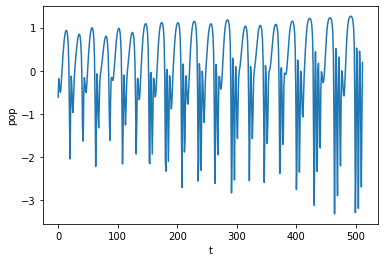

NSMap: 
 Min error 0.33159043115221865 
 Optimal Lags: 3 
 Theta: 15.521016654522507 
 Delta: 0.2721413465624998
SMap: 
 Min error 0.6376753412044227 
 Optimal Lags: 4 
 Theta: 24.24725756505177
Probability SMap beats NSMap:  2.4400095246461193e-75


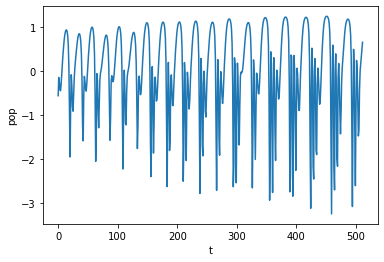

NSMap: 
 Min error 0.2050902404882105 
 Optimal Lags: 3 
 Theta: 17.043219260793695 
 Delta: 0.0
SMap: 
 Min error 0.45022769881667013 
 Optimal Lags: 4 
 Theta: 16.55851363856251
Probability SMap beats NSMap:  5.669259918944238e-104


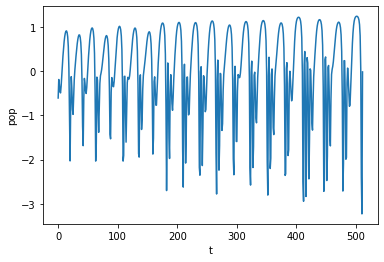

NSMap: 
 Min error 0.2005401683890168 
 Optimal Lags: 3 
 Theta: 26.111915554725844 
 Delta: 0.35996202934062504
SMap: 
 Min error 0.4363693099434554 
 Optimal Lags: 5 
 Theta: 26.111915554725844
Probability SMap beats NSMap:  9.149599701356479e-96


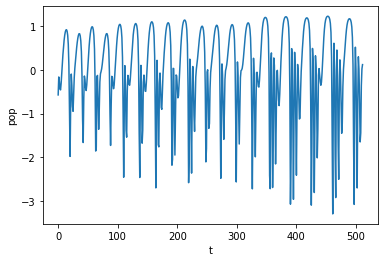

NSMap: 
 Min error 0.35855763498250215 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.7515430062500003
SMap: 
 Min error 0.7641362247119692 
 Optimal Lags: 5 
 Theta: 12.338323168875007
Probability SMap beats NSMap:  2.5463587917942575e-86


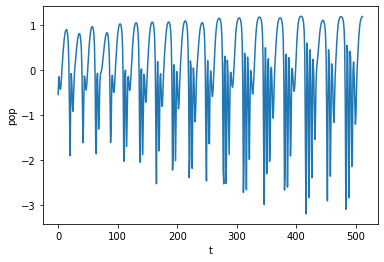

NSMap: 
 Min error 0.45397838519740413 
 Optimal Lags: 4 
 Theta: 22.738105049750768 
 Delta: 0.4401775472187503
SMap: 
 Min error 0.6939860455051174 
 Optimal Lags: 4 
 Theta: 24.299473167169463
Probability SMap beats NSMap:  5.212737954978909e-38


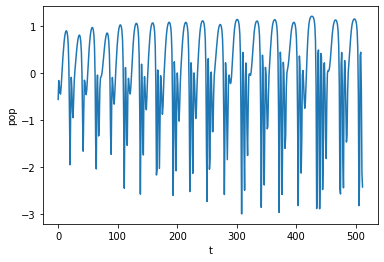

NSMap: 
 Min error 0.3216242784132232 
 Optimal Lags: 3 
 Theta: 15.913320201612631 
 Delta: 0.4888672238906252
SMap: 
 Min error 0.7295169901024282 
 Optimal Lags: 5 
 Theta: 16.88273144607501
Probability SMap beats NSMap:  2.7909041375408453e-99


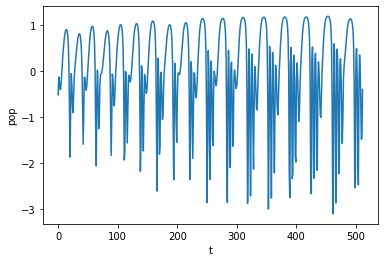

NSMap: 
 Min error 0.2458588812639262 
 Optimal Lags: 4 
 Theta: 13.644974522870632 
 Delta: 0.8504163128906252
SMap: 
 Min error 0.6019477622685092 
 Optimal Lags: 5 
 Theta: 13.270502955193693
Probability SMap beats NSMap:  1.9161472639008546e-85


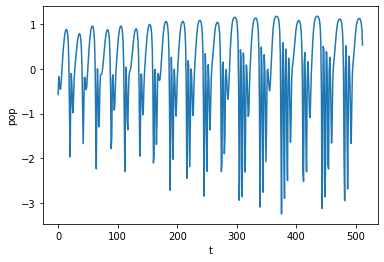

NSMap: 
 Min error 0.3695656407996884 
 Optimal Lags: 3 
 Theta: 16.88273144607501 
 Delta: 0.46012849687499996
SMap: 
 Min error 0.9248318449716193 
 Optimal Lags: 5 
 Theta: 12.607477538830631
Probability SMap beats NSMap:  1.2908308649235067e-110


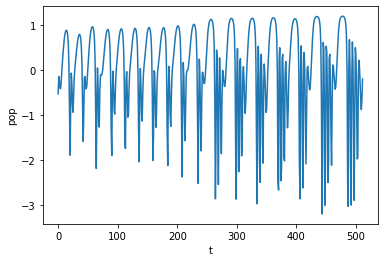

NSMap: 
 Min error 0.6032909176760723 
 Optimal Lags: 4 
 Theta: 14.834264389518758 
 Delta: 0.9194198242187502
SMap: 
 Min error 1.4289021180553327 
 Optimal Lags: 5 
 Theta: 11.242413389762506
Probability SMap beats NSMap:  1.4580044055310364e-81


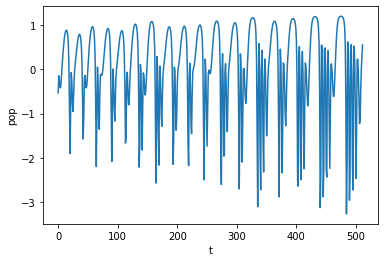

NSMap: 
 Min error 0.4537079857707504 
 Optimal Lags: 3 
 Theta: 15.012584183650633 
 Delta: 0.0
SMap: 
 Min error 0.8586852456323273 
 Optimal Lags: 5 
 Theta: 13.466654728738757
Probability SMap beats NSMap:  1.34504497185578e-97


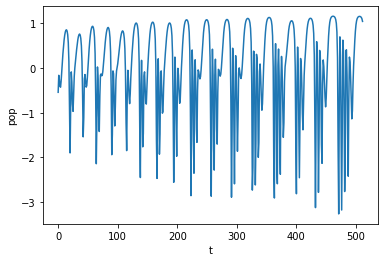

NSMap: 
 Min error 0.49789727018173036 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.52102590625
SMap: 
 Min error 0.9595639454536785 
 Optimal Lags: 5 
 Theta: 13.644974522870632
Probability SMap beats NSMap:  9.282859344004738e-81


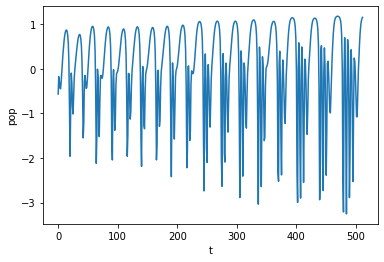

NSMap: 
 Min error 0.381920712112669 
 Optimal Lags: 3 
 Theta: 13.644974522870632 
 Delta: 0.7569950866406251
SMap: 
 Min error 0.9930724635140952 
 Optimal Lags: 5 
 Theta: 12.043579707500008
Probability SMap beats NSMap:  4.4573460498226196e-108


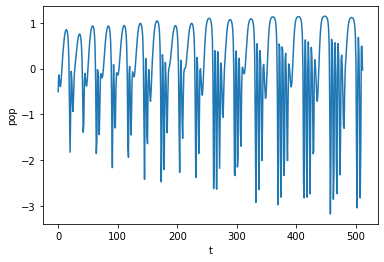

NSMap: 
 Min error 0.5992172927817787 
 Optimal Lags: 4 
 Theta: 14.789236799353827 
 Delta: 0.0011513416459960947
SMap: 
 Min error 1.5097765318765675 
 Optimal Lags: 4 
 Theta: 15.521016654522507
Probability SMap beats NSMap:  2.5462068854170162e-95


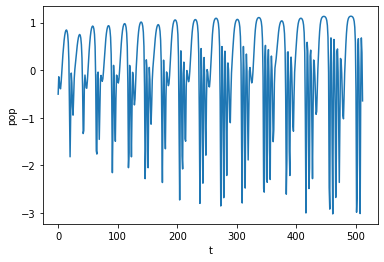

NSMap: 
 Min error 0.427046112433516 
 Optimal Lags: 3 
 Theta: 17.78081477288464 
 Delta: 0.6595388128906251
SMap: 
 Min error 0.9160419066930141 
 Optimal Lags: 5 
 Theta: 15.913320201612631
Probability SMap beats NSMap:  5.6113830617268906e-89


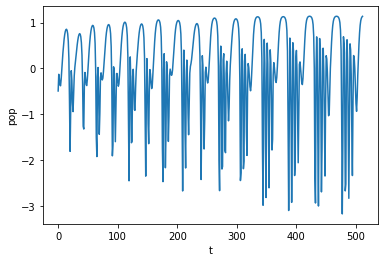

NSMap: 
 Min error 0.5593357328663432 
 Optimal Lags: 3 
 Theta: 14.493835691630633 
 Delta: 0.0
SMap: 
 Min error 1.4565829308536307 
 Optimal Lags: 5 
 Theta: 12.485694899562507
Probability SMap beats NSMap:  3.71485685975066e-133


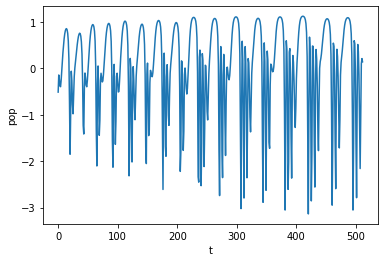

NSMap: 
 Min error 0.44670171885060755 
 Optimal Lags: 3 
 Theta: 13.891085313118756 
 Delta: 0.68798202171875
SMap: 
 Min error 1.4374205950070373 
 Optimal Lags: 5 
 Theta: 11.775631106250009
Probability SMap beats NSMap:  1.0175635728037563e-133


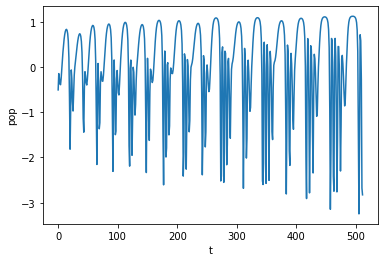

NSMap: 
 Min error 0.4619907494776568 
 Optimal Lags: 3 
 Theta: 15.353012881538758 
 Delta: 0.8359293267187499
SMap: 
 Min error 1.5348127913073772 
 Optimal Lags: 5 
 Theta: 12.176214265118757
Probability SMap beats NSMap:  2.0903845087004964e-132


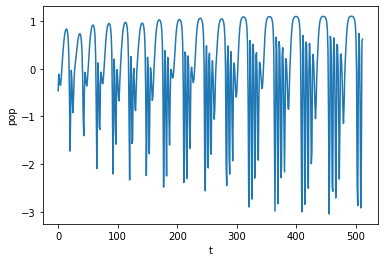

NSMap: 
 Min error 0.5334944276992931 
 Optimal Lags: 3 
 Theta: 14.053194216875006 
 Delta: 0.747479296875
SMap: 
 Min error 1.4579144120004206 
 Optimal Lags: 5 
 Theta: 17.56504782198507
Probability SMap beats NSMap:  9.267923642674109e-115


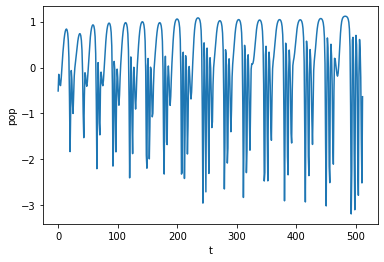

NSMap: 
 Min error 0.7223281080013959 
 Optimal Lags: 3 
 Theta: 12.043579707500008 
 Delta: 0.8522421875
SMap: 
 Min error 1.4410697336970242 
 Optimal Lags: 5 
 Theta: 15.697553250713062
Probability SMap beats NSMap:  9.453464283495643e-75


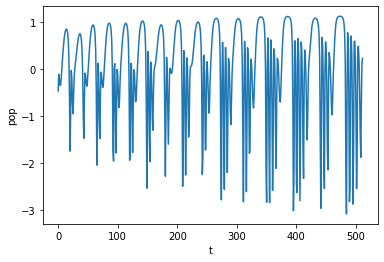

NSMap: 
 Min error 0.691073734764174 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.84080390625
SMap: 
 Min error 1.9501608390944607 
 Optimal Lags: 5 
 Theta: 15.342696860390632
Probability SMap beats NSMap:  3.6370307389313754e-114


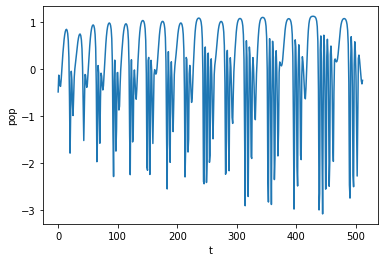

NSMap: 
 Min error 0.7753424283424146 
 Optimal Lags: 4 
 Theta: 11.757490014631705 
 Delta: 0.9829480642740429
SMap: 
 Min error 1.8447004896021797 
 Optimal Lags: 4 
 Theta: 13.891085313118756
Probability SMap beats NSMap:  2.245687314329678e-57


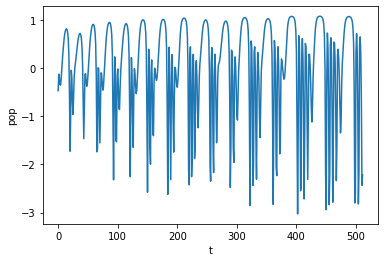

NSMap: 
 Min error 0.5882876569405595 
 Optimal Lags: 4 
 Theta: 11.775631106250009 
 Delta: 0.49386140625000013
SMap: 
 Min error 1.6738889060844366 
 Optimal Lags: 5 
 Theta: 11.628259375562507
Probability SMap beats NSMap:  2.5901705642426187e-113


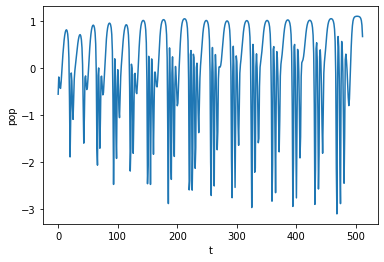

NSMap: 
 Min error 0.5898835095384538 
 Optimal Lags: 3 
 Theta: 14.347937678250007 
 Delta: 0.8623064062500003
SMap: 
 Min error 1.9606523158964833 
 Optimal Lags: 5 
 Theta: 13.270502955193693
Probability SMap beats NSMap:  6.330577150187033e-133


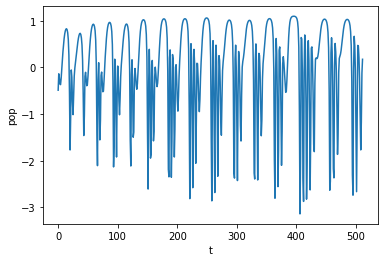

NSMap: 
 Min error 0.836423260100106 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.9999
SMap: 
 Min error 2.798121545372359 
 Optimal Lags: 4 
 Theta: 17.417690828470636
Probability SMap beats NSMap:  9.436666954527983e-98


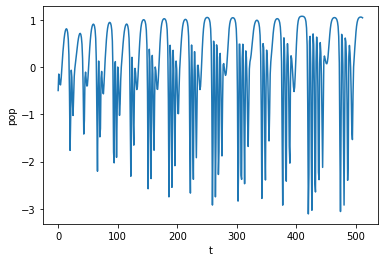

NSMap: 
 Min error 0.7209337009564486 
 Optimal Lags: 3 
 Theta: 14.834264389518758 
 Delta: 0.6571520217187503
SMap: 
 Min error 2.2578322718545976 
 Optimal Lags: 5 
 Theta: 14.672155485762508
Probability SMap beats NSMap:  7.667371738331037e-133


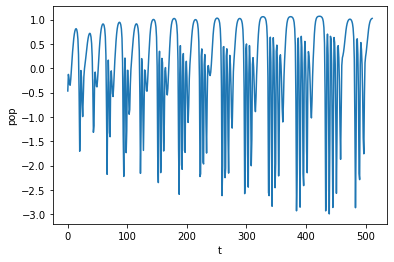

NSMap: 
 Min error 0.6731045968581222 
 Optimal Lags: 3 
 Theta: 16.55851363856251 
 Delta: 0.8358839765625002
SMap: 
 Min error 1.8271058423577953 
 Optimal Lags: 5 
 Theta: 18.173118319974765
Probability SMap beats NSMap:  7.20520552310383e-112


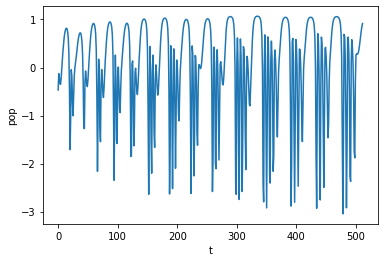

NSMap: 
 Min error 0.9078622025183325 
 Optimal Lags: 3 
 Theta: 14.281620399440632 
 Delta: 0.961198575390625
SMap: 
 Min error 2.6678784674465987 
 Optimal Lags: 5 
 Theta: 12.947906236718756
Probability SMap beats NSMap:  4.968674584655177e-111


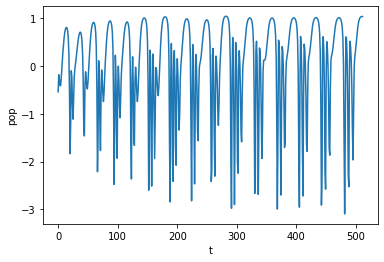

NSMap: 
 Min error 0.5736135749792468 
 Optimal Lags: 3 
 Theta: 12.515861853981688 
 Delta: 0.9829480642740429
SMap: 
 Min error 1.912199939678029 
 Optimal Lags: 5 
 Theta: 18.367308575784378
Probability SMap beats NSMap:  2.1717959868486553e-116


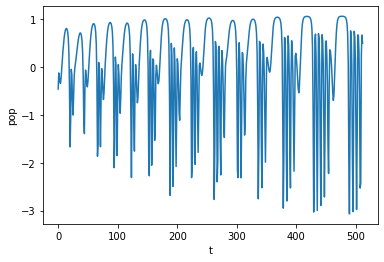

NSMap: 
 Min error 0.795947599045843 
 Optimal Lags: 3 
 Theta: 16.210110376320596 
 Delta: 0.09831589868723056
SMap: 
 Min error 2.425339548220543 
 Optimal Lags: 5 
 Theta: 13.172427068421163
Probability SMap beats NSMap:  2.5609929331912827e-136


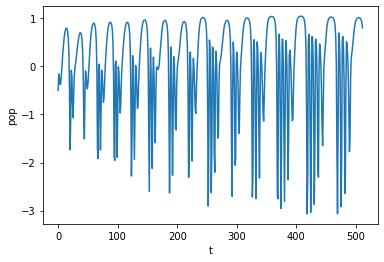

NSMap: 
 Min error 0.766377434672814 
 Optimal Lags: 4 
 Theta: 15.521016654522507 
 Delta: 0.8675882015624999
SMap: 
 Min error 2.146560761148276 
 Optimal Lags: 5 
 Theta: 20.6588962501731
Probability SMap beats NSMap:  4.164631802256232e-104


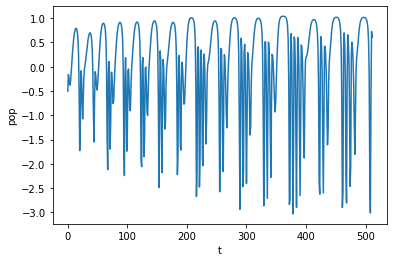

NSMap: 
 Min error 0.7278525920528408 
 Optimal Lags: 3 
 Theta: 16.751218387326787 
 Delta: 0.960779905701172
SMap: 
 Min error 2.893711901095263 
 Optimal Lags: 4 
 Theta: 18.604652221773904
Probability SMap beats NSMap:  8.938603381183302e-137


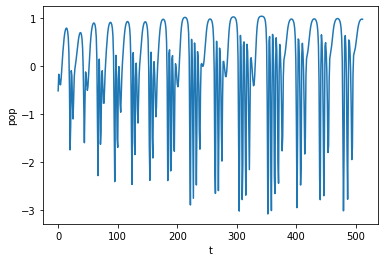

NSMap: 
 Min error 0.640358919773253 
 Optimal Lags: 3 
 Theta: 20.06330813777264 
 Delta: 0.8489603366406251
SMap: 
 Min error 2.1497573167351924 
 Optimal Lags: 5 
 Theta: 16.109471975157692
Probability SMap beats NSMap:  4.867065358768173e-136


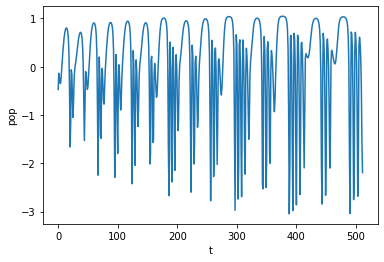

NSMap: 
 Min error 0.680686478405433 
 Optimal Lags: 3 
 Theta: 15.697553250713062 
 Delta: 0.9482815063476563
SMap: 
 Min error 3.2544187636157718 
 Optimal Lags: 4 
 Theta: 14.834264389518758
Probability SMap beats NSMap:  1.003747231850776e-157


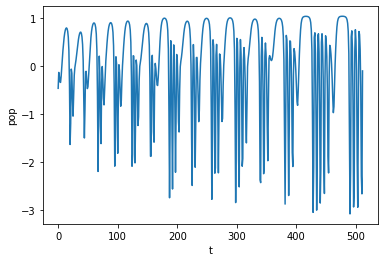

NSMap: 
 Min error 0.6784247410220545 
 Optimal Lags: 3 
 Theta: 17.23937103433876 
 Delta: 0.8249618867187498
SMap: 
 Min error 2.5320100170009017 
 Optimal Lags: 5 
 Theta: 12.176214265118757
Probability SMap beats NSMap:  1.069827725073055e-146


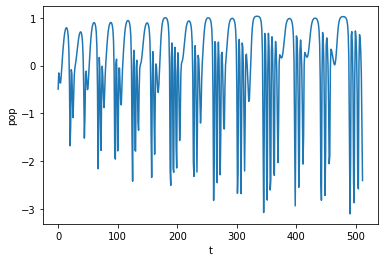

NSMap: 
 Min error 0.7612416891984966 
 Optimal Lags: 3 
 Theta: 16.23429583105001 
 Delta: 0.9288564062500002
SMap: 
 Min error 2.2883132047519674 
 Optimal Lags: 5 
 Theta: 13.644974522870632
Probability SMap beats NSMap:  3.848575505953404e-117


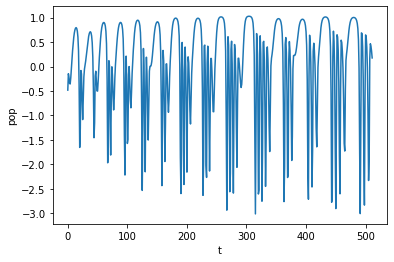

NSMap: 
 Min error 0.7087991461670486 
 Optimal Lags: 4 
 Theta: 14.053194216875006 
 Delta: 0.8833320468750001
SMap: 
 Min error 2.2066263019458354 
 Optimal Lags: 5 
 Theta: 14.053194216875006
Probability SMap beats NSMap:  2.5306383393903322e-116


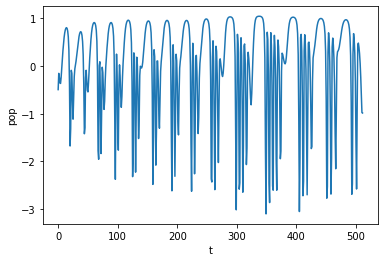

NSMap: 
 Min error 0.6869422743864542 
 Optimal Lags: 3 
 Theta: 13.463132912804653 
 Delta: 0.9829480642740429
SMap: 
 Min error 1.7205097141272887 
 Optimal Lags: 5 
 Theta: 14.347937678250007
Probability SMap beats NSMap:  2.4590537360056962e-90


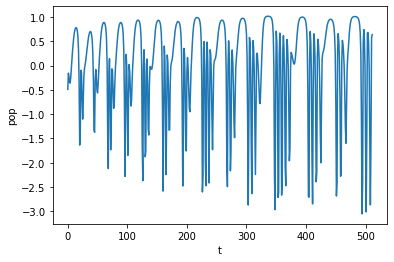

NSMap: 
 Min error 1.095761889013787 
 Optimal Lags: 4 
 Theta: 14.347937678250007 
 Delta: 0.9073539062500001
SMap: 
 Min error 2.674091771071277 
 Optimal Lags: 5 
 Theta: 13.555814625804693
Probability SMap beats NSMap:  8.577912079667666e-87


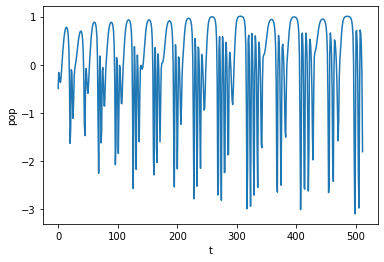

NSMap: 
 Min error 0.8667495423421788 
 Optimal Lags: 3 
 Theta: 16.380193844430636 
 Delta: 0.9501845503906251
SMap: 
 Min error 2.7821975714783287 
 Optimal Lags: 5 
 Theta: 13.891085313118756
Probability SMap beats NSMap:  1.2969149948206057e-123


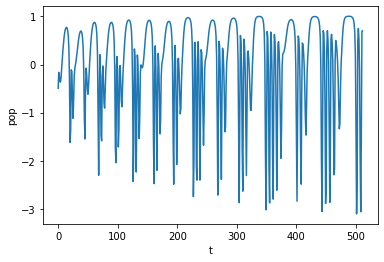

NSMap: 
 Min error 0.8363151846440093 
 Optimal Lags: 3 
 Theta: 13.466654728738757 
 Delta: 0.95358639921875
SMap: 
 Min error 3.6509562404289837 
 Optimal Lags: 5 
 Theta: 12.043579707500008
Probability SMap beats NSMap:  5.587198587148785e-156


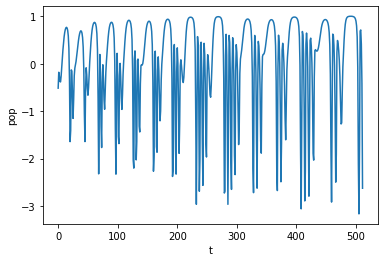

NSMap: 
 Min error 0.9574177980476024 
 Optimal Lags: 4 
 Theta: 15.521016654522507 
 Delta: 0.8694917265625001
SMap: 
 Min error 3.3814412492683763 
 Optimal Lags: 5 
 Theta: 11.84261825656251
Probability SMap beats NSMap:  4.774412726070011e-131


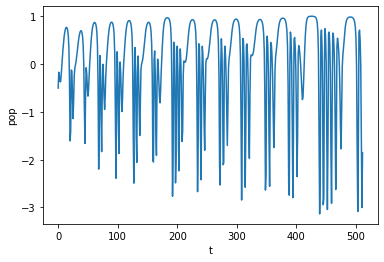

NSMap: 
 Min error 0.7838439196885596 
 Optimal Lags: 4 
 Theta: 12.338323168875007 
 Delta: 0.7981480468750003
SMap: 
 Min error 2.925286639729338 
 Optimal Lags: 5 
 Theta: 12.043579707500008
Probability SMap beats NSMap:  4.374110194323251e-138


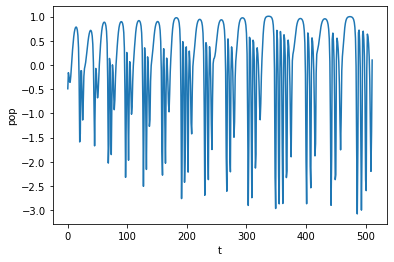

NSMap: 
 Min error 0.5773775230945992 
 Optimal Lags: 3 
 Theta: 14.798366772813377 
 Delta: 0.9829480642740429
SMap: 
 Min error 2.013596460132902 
 Optimal Lags: 5 
 Theta: 14.200565947562506
Probability SMap beats NSMap:  1.2960755580567974e-126


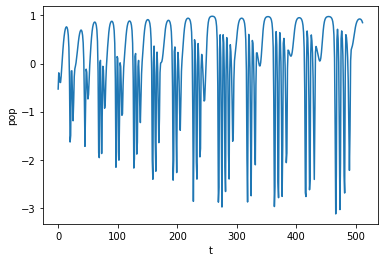

NSMap: 
 Min error 0.7986353985975198 
 Optimal Lags: 4 
 Theta: 12.140603896012628 
 Delta: 0.9390540628906249
SMap: 
 Min error 2.128181358291852 
 Optimal Lags: 5 
 Theta: 12.485694899562507
Probability SMap beats NSMap:  9.528350989595966e-93


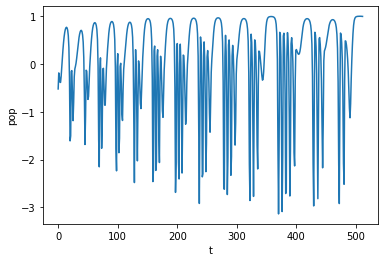

NSMap: 
 Min error 0.8135231201431539 
 Optimal Lags: 4 
 Theta: 14.347937678250007 
 Delta: 0.9106814062499999
SMap: 
 Min error 2.8875623979224403 
 Optimal Lags: 5 
 Theta: 12.412009034218757
Probability SMap beats NSMap:  1.5609907498292264e-130


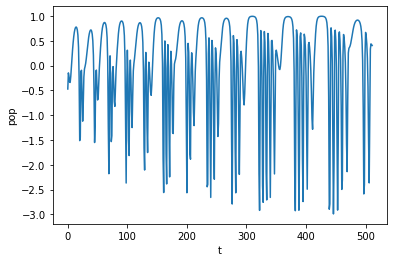

NSMap: 
 Min error 0.5843514670864547 
 Optimal Lags: 4 
 Theta: 12.338323168875007 
 Delta: 0.8947717968750001
SMap: 
 Min error 1.9021964481456577 
 Optimal Lags: 5 
 Theta: 14.493835691630633
Probability SMap beats NSMap:  2.3405491094192725e-118


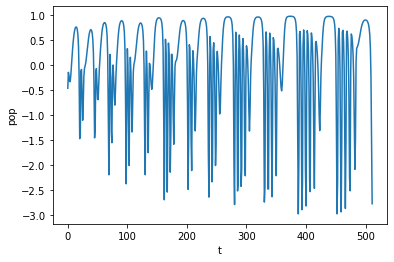

KeyboardInterrupt: 

In [5]:
datums = driverVdelta(100)

In [44]:
# weightDropoff = (1-datums[:,2])**(1/10)
# pcc = np.corrcoef(datums[:,0],weightDropoff)[0,1]

In [45]:
"""
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(datums[:,0], weightDropoff)
ax.set_ylabel("Drop in weight over 10% of series")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.8,0.98,f"r={pcc:.3f}")
plt.show()
"""


'\n# plotTS((1-datums[:,2])**0.1)\nfig, ax = plt.subplots(1)\n#ax.plot(datums[:,0], (1-datums[:,2])**0.1)\n\nax.plot(datums[:,0], weightDropoff)\nax.set_ylabel("Drop in weight over 10% of series")\nax.set_xlabel("Rate of nonstationary change")\nax.text(0.8,0.98,f"r={pcc:.3f}")\nplt.show()\n'

In [46]:
# np.save("driverVdelta_4", datums)

In [47]:
# datums2 = np.load("driverVdelta_2.npy")

In [48]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
# x0 = np.array([0.49])
x0 = np.array([0.1,0.4,9])

# m = 50
# x0 = np.ones(m) * (np.pi ** -1)
# x0[0] += 0.2
# x0[1] += 0.3
# x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 3 - 0.5 * t / tlen
# m = lambda t: 0.3
# b1 = lambda t: 4 + 2 * np.sin(2*np.pi*t / end)
b1 = lambda t: 3 + 3.5 * t / end

""" GENERATE TS """
# Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=tlen, end=end, reduction=reduction, settlingTime=settlingTime)
Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
# Xr = generateTimeSeriesDiscrete("LogisticIslandsP", x0, nsargs=(r, m), tlen=tlen, settlingTime=settlingTime)[:,4,None]

In [49]:
"""
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(Xc[:,1], Xc[:,0])
ax.set_xlabel("Juveniles")
ax.set_ylabel("Adults")

# ax[1].plot(Xr[::5,1])
# ax[1].set_ylabel("Juveniles")
# ax[2].plot(Xr[::5,0])
# ax[2].set_ylabel("Adults")
plt.tight_layout()
plt.show()
"""

'\nfig, ax = plt.subplots(1, figsize=(6,4))\nax.scatter(Xc[:,1], Xc[:,0])\nax.set_xlabel("Juveniles")\nax.set_ylabel("Adults")\n\n# ax[1].plot(Xr[::5,1])\n# ax[1].set_ylabel("Juveniles")\n# ax[2].plot(Xr[::5,0])\n# ax[2].set_ylabel("Adults")\nplt.tight_layout()\nplt.show()\n'

In [51]:
# poincareT(Xc[:,1],xlabel="Juveniles(t)", ylabel="Juveniles(t-1)")

In [52]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [53]:

""" UPDATE DRIVERS HERE """

digiDrivers = [b1]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = b1(t) # driverArray
# gtsr = c(t)

<IPython.core.display.Javascript object>


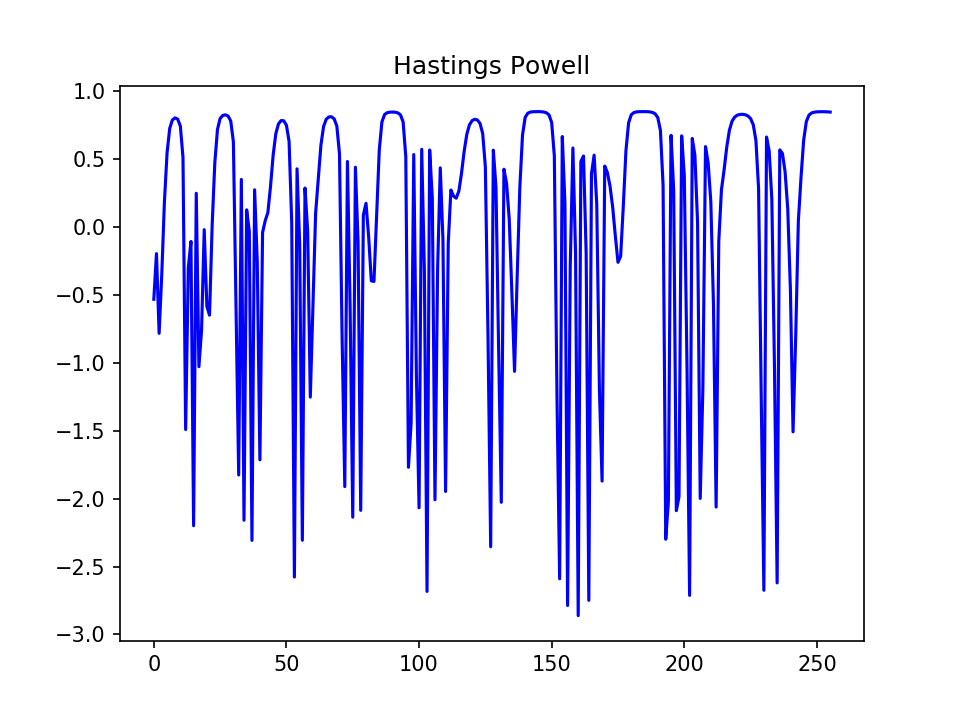

<IPython.core.display.Javascript object>


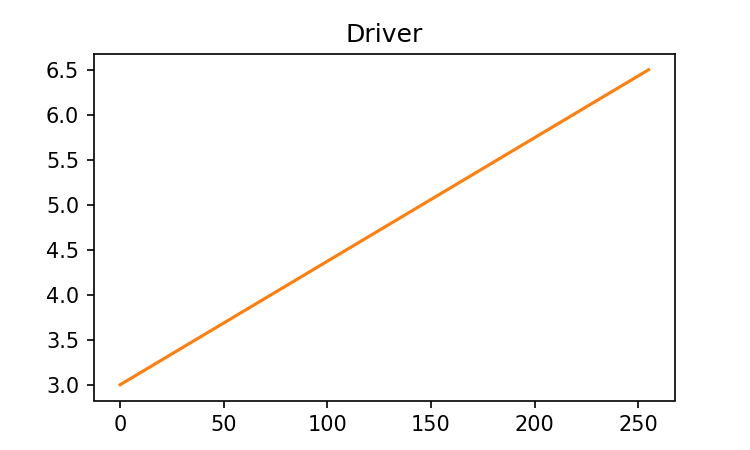

In [54]:
fig2 = plt.figure(2)

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2], linewidth=1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x(t)")
    ax2.set_ylabel("y(t)")
    ax2.set_zlabel("z(t)")
    
ax2.set_title("Hastings Powell")
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [160]:
def MDStimescaleDecomp(Xr, lags=3, window_size=0.2):
    X, _ = delayEmbed(Xr, 1, lags, 1)
    
    n = X.shape[0]
    
    distance_matrix = distanceMatrix(Xr)
    
    similarity_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            similarity = dynamicSimilarity(distance_matrix, i, j)
            similarity_matrix[i,j] = similarity
            similarity_matrix[j,i] = similarity
        print(f"{i},{j}:{similarity_matrix[i,j]}")
            
    similarity_matrix = standardize(similarity_matrix)
    
    fig, ax = plt.subplots(1)
    ax.imshow(similarity_matrix)
    plt.show()
    
    embedding = MDS(dissimilarity="precomputed")
    X_transformed = embedding.fit_transform(similarity_matrix)
    
    return X_transformed
    
def dynamicSimilarity(X, t1, t2):
    
    
"""
def dynamicSimilarity(distance_matrix, t1, t2, window_size=0.2):
    n = distance_matrix.shape[0]
    n_neighbors = 3
    
    win_radius = int(n * window_size)
    
    U = max(0, t1-win_radius)
    D = min(n, t1+win_radius)
    L = max(0, t2-win_radius)
    R = min(n, t2+win_radius)
    
    window = distance_matrix[U:D, L:R]

    distance = np.mean(np.exp(-window))
    
    return distance

    dynamic_similarity = 0
    for x1 in window1:
        neighbors = nearestNeighbors(x1, window2, n_neighbors)
        for neighbor in neighbors:
            dynamic_similarity += la.norm(neighbor-x1)**2
    
    return dynamic_similarity / (n*n_neighbors)
    
"""
def distanceMatrix(X):
    n = X.shape[0]
    
    distance_matrix = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            distance_matrix[i,j] = la.norm(X[i]-X[j])
            
    return distance_matrix

<IPython.core.display.Javascript object>


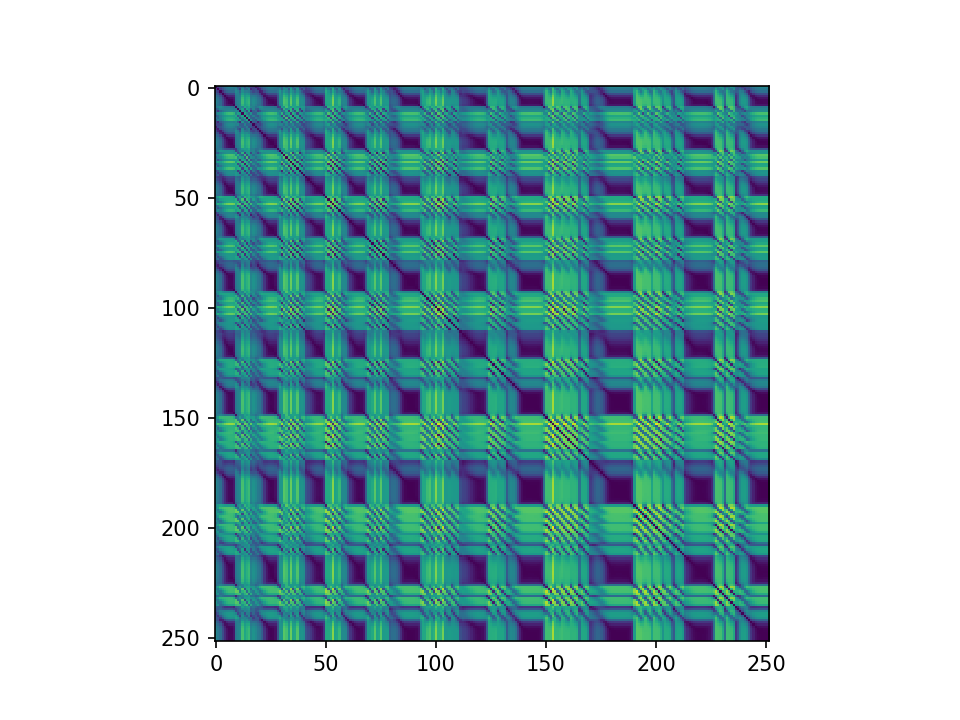

In [171]:
dist = distanceMatrix(X)
fig, ax = plt.subplots(1)
ax.imshow(dist)
plt.show()

In [162]:
dist

array([[0.00000000e+00, 9.65506515e-01, 1.35170933e+00, ...,
        2.66083310e+00, 2.66240015e+00, 2.66241545e+00],
       [9.65506515e-01, 0.00000000e+00, 9.74381417e-01, ...,
        2.36898042e+00, 2.37066162e+00, 2.37085114e+00],
       [1.35170933e+00, 9.74381417e-01, 0.00000000e+00, ...,
        2.14656341e+00, 2.14884276e+00, 2.14946710e+00],
       ...,
       [2.66083310e+00, 2.36898042e+00, 2.14656341e+00, ...,
        0.00000000e+00, 2.48810136e-03, 3.58901616e-03],
       [2.66240015e+00, 2.37066162e+00, 2.14884276e+00, ...,
        2.48810136e-03, 0.00000000e+00, 1.31177789e-03],
       [2.66241545e+00, 2.37085114e+00, 2.14946710e+00, ...,
        3.58901616e-03, 1.31177789e-03, 0.00000000e+00]])

In [216]:
print(dynamicSimilarity(dist, 0, 100), dynamicSimilarity(dist, 100, 0))

0.18890127660675463 0.18890127660675463


In [217]:
lags=3
window_size=0.5

X, _ = delayEmbed(Xr, 1, lags, 1)
    
n = X.shape[0]

distance_matrix = distanceMatrix(X)

similarity_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        similarity_matrix[i,j] = dynamicSimilarity(distance_matrix, i, j, window_size=window_size)
    print(f"{i},{j}:{similarity_matrix[i,j]}")

0,251:0.17197487448697224
1,251:0.17132315088094827
2,251:0.1705442571533021
3,251:0.16999970142873697
4,251:0.1694209951385601
5,251:0.16886530742719236
6,251:0.1683480432179186
7,251:0.16845554990711503
8,251:0.16819339099602185
9,251:0.16782872778100671
10,251:0.16747322824954938
11,251:0.16719288808245403
12,251:0.16735801142177195
13,251:0.16813847387367784
14,251:0.16932624960761222
15,251:0.17060138412529133
16,251:0.17186080170269957
17,251:0.17309812344242836
18,251:0.17431632799480487
19,251:0.17551849802963032
20,251:0.1767064847680893
21,251:0.17787813785581388
22,251:0.17900005173830136
23,251:0.1798343744206778
24,251:0.17945718288607984
25,251:0.1787710916778779
26,251:0.17809637953043975
27,251:0.177430421642069
28,251:0.1764698007251732
29,251:0.17572495174720307
30,251:0.1749944133985311
31,251:0.17431653457727536
32,251:0.17359251320885508
33,251:0.1729220239340856
34,251:0.1722679018363614
35,251:0.1716540000939976
36,251:0.17104626398681647
37,251:0.170437269433877

<IPython.core.display.Javascript object>


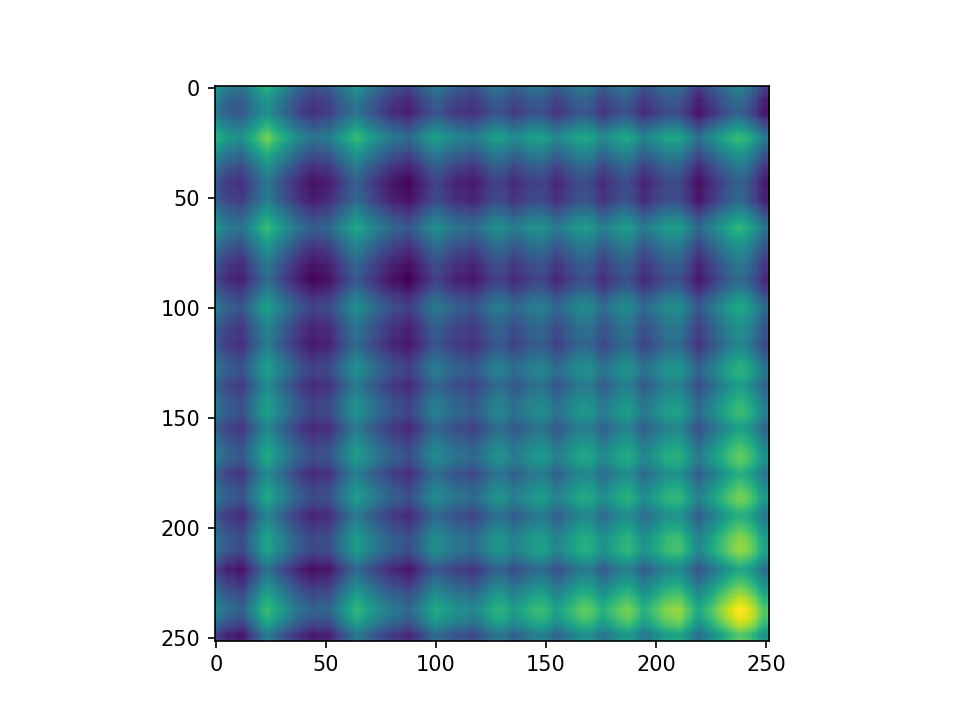

In [219]:
fig, ax = plt.subplots(1)
ax.imshow(similarity_matrix)
plt.show()

In [220]:
"""
n = 100
similarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))
similarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8
"""

'\nn = 100\nsimilarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))\nsimilarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8\n'

In [221]:
embedding = MDS(dissimilarity="precomputed", n_components=10)
X_transformed = embedding.fit_transform(similarity_matrix)

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype

<IPython.core.display.Javascript object>


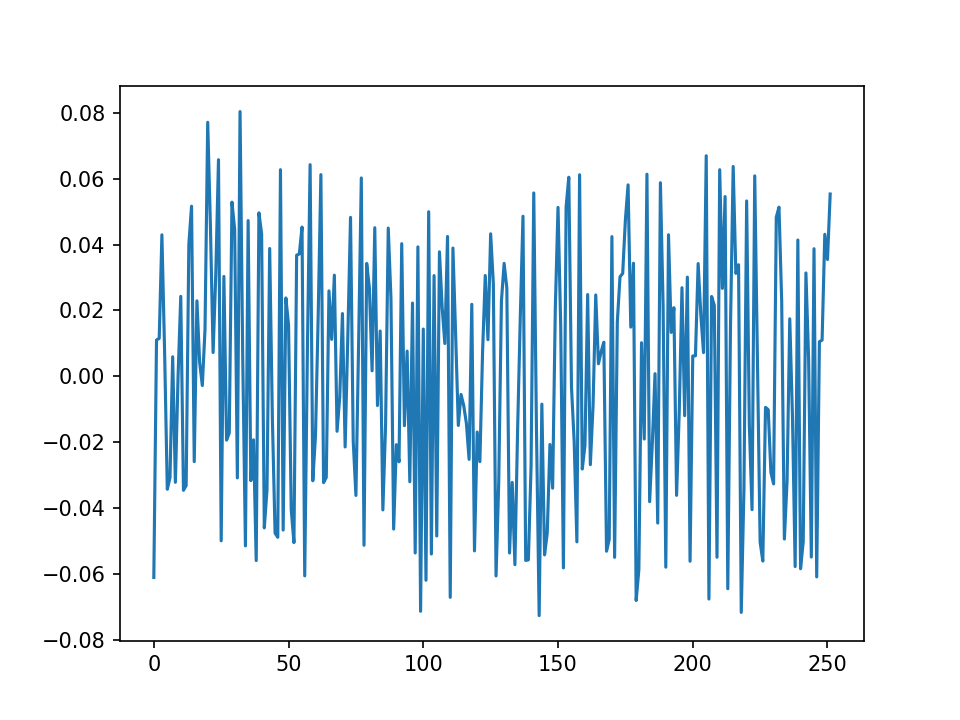

In [227]:
fig, ax = plt.subplots(1)
ax.plot(X_transformed[:,0])
plt.show()

In [62]:
transformed = MDStimescaleDecomp(Xr)

0,251:639.210889219977
1,251:652.1435382948912
2,251:661.7399754436877
3,251:672.0413350046916
4,251:684.1945445043644
5,251:701.574972872126
6,251:711.8584619063646
7,251:723.7383553552442
8,251:731.6705683033872
9,251:740.1749921528325
10,251:750.0580710390454
11,251:760.271750196645
12,251:762.7832063090381
13,251:765.6345108906488
14,251:778.169912700936
15,251:791.4698285743274
16,251:797.1429500975668
17,251:803.0110122163203
18,251:810.449282561496
19,251:820.6565056877239
20,251:833.296391616657
21,251:850.6722323484457
22,251:861.0604328872314
23,251:874.186179391334
24,251:891.5841575432157
25,251:901.8999445468974
26,251:907.6900272845448
27,251:921.1356171992506
28,251:935.3304333759747
29,251:946.240433651473
30,251:957.7833916257503
31,251:970.1858027555845
32,251:994.2260793055258
33,251:1005.2431915934451
34,251:1024.1078495273377
35,251:1035.4104271665992
36,251:1048.0737134342296
37,251:1061.8189341598666
38,251:1086.60496475029
39,251:1110.9028607728303
40,251:1134.7

<IPython.core.display.Javascript object>

ValueError: Array must be symmetric

In [ ]:
poincare3d(Xr[:,0,None], title="Hastings Powell", scatter=False, step=1)

In [ ]:
poincare2d(Xr, step = 1)

In [ ]:
poincareT(Xr,step=1, scatter=False)

In [ ]:
poincare3d(Xr, title="Hastings Powell")

In [ ]:
FNNplot(Xr, 5, 4)

In [ ]:
predictionHorizon = 1
numLags = 1
lagStep = 1
maxLags = 6

In [ ]:
thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep)

In [ ]:
print(thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS)

In [ ]:
# thetaBestNS, deltaBestNS, lagBestNS, errorNS, landNS = NSMapOptimize(Xr, tr, predictionHorizon, maxLags, lagStep, thetaVals, deltaVals, returnLandscape=True)

In [ ]:
# thetaBestS, lagBestS, errorS, landS = SMapOptimize(Xr, tr, predictionHorizon,maxLags,lagStep, thetaVals, returnLandscape=True)

In [ ]:
""" COMPUTE DOFS """

Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagsS, lagStep, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaNS, 0)

In [ ]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaNS, deltaNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaNS, 0)

In [ ]:
MSENS = np.sum((predictedTSNS - Yn) ** 2 )
MSES = np.sum((predictedTSS - Ys) ** 2 )

In [ ]:
figLOU, axLOU = plt.subplots(2, figsize=(8,8))
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

In [ ]:
MSENS, sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS, returnSeries=True)
MSES, sequentialS = sequential(Xs, Ys, txs, thetaS, 0, returnSeries=True)

In [ ]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(Yn[int(Yn.shape[0]/2):], color="blue")
ax[0].plot(sequentialNS, color="green", linestyle="dashed", label="NSMap Predictions")
ax[0].text(75,-3,f"Improvement of NSMap = {MSES/MSENS:.4f}")
ax[0].legend()

ax[1].plot(Ys[int(Ys.shape[0]/2):], color="blue")
ax[1].plot(sequentialS, color="silver", linestyle="dashed", label="SMap Prediction")
ax[1].legend()

plt.show()

In [ ]:
# functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

In [ ]:
# functionSurfaceSMap(Xr, predictionHorizon, thetaBestS, 15)

In [ ]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaNS:.3f}, delta: {deltaNS:.7f}, Min Error: {errNS:.3f}, Optimal Embedding Dimension: {lagsNS+2}, MSE: {MSENS}, 10% Weight Dropoff: {(1-deltaNS)**(0.1)}")
print(f"SMap -- theta: {thetaS:.3f}, Min Error: {errS:.3f}, Optimal Embedding Dimension: {lagsS+2}, MSE: {MSES}")

print(f"Improvement of NSMap: {errS/errNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(errNS, errS, dofNS, dofS, Xr.shape[0])

In [ ]:
# fix, ax = plt.subplots(1)
# ax.imshow(landNS[1:,1:,2])

In [ ]:
deltaNS

In [ ]:
driverVdelta = np.array([[0, 0.9939017526504343],
          [0.5, 0.913616621633756],
          [1, 0.9404808557939969],
          [1.5, 0.8986395799598124],
          [2.0, 0.7594675023780507],
          [2.5, 0.7385951709456133],
          [3.0, 0.7735371385558871],
          [3.5, 0.9095528584046055]])

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(driverVdelta[:,0],driverVdelta[:,1])
ax.set_xlabel("Slope of driver")
ax.set_ylabel("Drop in weight over 10% of series length")
ax.text(1.55,0.98,f"r={np.corrcoef(driverVdelta[:,0],driverVdelta[:,1])[0,1]}")